# What the 'curse of dimensionality' tells us
http://www.visiondummy.com/2014/04/curse-dimensionality-affect-classification/

* At a certain point, increasing the number of features (or to name 'dimensionality') at a certain will diminish in benefit and will eventually further lead to a decerase in performance
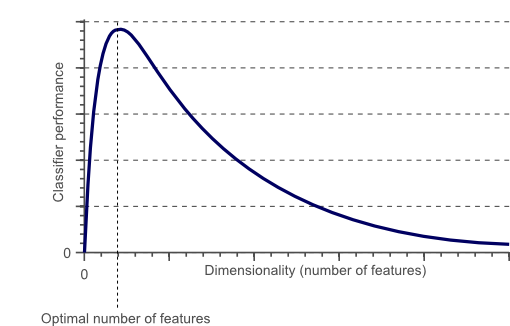
* As more features are added, the increased idmensionality find it easier for the model to find the hyperplane that separates the classes. On the other hand, this means this will lead to overfitting
### "In other words, if the amount of available training data is fixed, then overfitting occurs if we keep adding dimensions. On the other hand, if we keep adding dimensions, the amount of training data needs to grow exponentially fast to maintain the same coverage and to avoid overfitting."

So... to avoid this curse:
* Note this will depend highly on amount of data, the diffculty of a decision boundary, and the type of classifier
* Models with non-linear boundary tend to overfit e.g. KNN, neural networks, forest models
* Overfitting occurs when we have too small data with high dimensionality, and too big data with low dimensionality --> find the goldilocks zone
* An increase of classifier variance indicates overfitting
* PCA/PCR could be used to reduce dimensionality


Therefore, in this approach we try to following:
1. Train the logistic regression model on base data with original data
2. Use permutation importance to select most important features
3. Experiment between 50, 100, 150, and 200 to see how many of the features we should keep
4. With a decision made on how many to keep, perform dfs to generate back to 300 features
5. Use permutation importance to reduce the features down to 50, 100, and 150 to again check
6. Given the following final set of data, we build our final solution data

*our CV will be  K-fold

In [95]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer
from keras.layers import *
from keras.metrics import *
from keras.models import Model
from keras.callbacks import *
from keras.optimizers import *
from keras.applications import *
from keras import activations
from keras import utils
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from eli5.sklearn import PermutationImportance
import featuretools as ft
import json
import ast
import time
from sklearn import linear_model
import eli5
import gc
gc.enable()
gc.collect()

86

In [142]:
train_df = pd.read_csv("/Users/JoonH/dont-overfit-ii/train.csv")
test_df = pd.read_csv("/Users/JoonH/dont-overfit-ii/test.csv")

In [143]:
train_df.target.sum() # Shows us we have a 90:160 class diff, thus maximum number of folds would be 90

160.0

In [144]:
x_train = train_df.drop(['id','target'], axis = 1)
y_train = train_df['target']
X_test = test_df.drop(['id'], axis = 1)
n_fold = 90
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=n_fold, n_repeats=20, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(X_test)

In [17]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [145]:
model = linear_model.LogisticRegression(class_weight=None, penalty='l1', C=0.08, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7167, std: 0.2867.


In [146]:
#Given this model, let's configure permutation importnace
perm = PermutationImportance(model, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, top=10)

Weight,Feature
0.1208 ± 0.0442,x33
0.0536 ± 0.0306,x65
0.0368 ± 0.0359,x217
0.0200 ± 0.0248,x91
0.0160 ± 0.0101,x189
0.0128 ± 0.0118,x73
0.0120 ± 0.0175,x117
0.0104 ± 0.0235,x199
0.0088 ± 0.0128,x258
0.0064 ± 0.0039,x129


In [147]:
def select_features(max_f = 50):
    sel = SelectFromModel(perm,threshold=-np.inf, prefit=True, max_features = max_f)
    X_trans = sel.transform(X_train)
    X_test_trans = sel.transform(X_test)
    model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.09, solver='liblinear', max_iter = 50000)
    oof_lr, prediction_lr, _ = train_model(X_trans, X_test_trans, y_train, params=None, model_type='sklearn', model=model)
    return prediction_lr

In [150]:
select_features(max_f=10)
select_features(max_f=20)
select_features(max_f=30)
select_features(max_f=40)
select_features(max_f=50)
select_features(max_f=60)
select_features(max_f=70)
select_features(max_f=80)
select_features(max_f=90)
select_features(max_f=100)
select_features(max_f=150)

CV mean score: 0.7778, std: 0.2485.
CV mean score: 0.7606, std: 0.2681.


'select_features(max_f=20)\nselect_features(max_f=30)\nselect_features(max_f=40)\nselect_features(max_f=50)\nselect_features(max_f=60)\nselect_features(max_f=70)\nselect_features(max_f=80)\nselect_features(max_f=90)\nselect_features(max_f=100)\nselect_features(max_f=150)'

In [83]:
#CV mean score relatively high with low std dev at 20 features
eli5.show_weights(perm, top=50)

Weight,Feature
0.1208 ± 0.0442,x33
0.0536 ± 0.0306,x65
0.0368 ± 0.0359,x217
0.0200 ± 0.0248,x91
0.0160 ± 0.0101,x189
0.0128 ± 0.0118,x73
0.0120 ± 0.0175,x117
0.0104 ± 0.0235,x199
0.0088 ± 0.0128,x258
0.0064 ± 0.0082,x108


In [92]:
columns_to_keep = ['33','65','217','91','189','73','117','199','258','108','129','194','90','80','82','165','183','43','226','133']
#columns_to_keep = pd.DataFrame(columns_to_keep,columns = ['features'])
#columns_to_keep = columns_to

In [98]:
perm_train = train_df[columns_to_keep]
perm_test = test_df[columns_to_keep]

In [94]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.09, solver='liblinear', max_iter = 50000)
oof_lr, prediction_lr, _ = train_model(X_trans, X_test_trans, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7583, std: 0.2485.


Now to build some new features

In [99]:

# initialize entityset
es = ft.EntitySet('data')
es2 = ft.EntitySet('test')

# add entities (application table itself)
es.entity_from_dataframe(
    entity_id='main', # define entity id
    dataframe=perm_train, # select underlying data
    index='id', # define unique index column
    # specify some datatypes manually (if needed)
    variable_types={
        f: ft.variable_types.Categorical 
        for f in train_df.columns if f.startswith('FLAG_')
    }
)

es2.entity_from_dataframe(
    entity_id='test', # define entity id
    dataframe=perm_test, # select underlying data
    index='id', # define unique index column
    # specify some datatypes manually (if needed)
    variable_types={
        f: ft.variable_types.Categorical 
        for f in train_df.columns if f.startswith('FLAG_')
    }
)

2019-03-09 11:11:14,296 featuretools.entityset - WARNING    index id not found in dataframe, creating new integer column
2019-03-09 11:11:14,305 featuretools.entityset - WARNING    index id not found in dataframe, creating new integer column


Entityset: test
  Entities:
    test [Rows: 19750, Columns: 21]
  Relationships:
    No relationships

In [100]:
#The actual feature construction
# see feature set definitions (no actual computations yet)
# used for faster prototyping
fm_train,feature_defs = ft.dfs(
    entityset=es, 
    target_entity="main", 
    features_only=False,
    agg_primitives=[
        "mean",
        "mode", 
        "max", 
        "min", 
        "sum", 
        "std"
        
    ],
    trans_primitives=[
        "not",
        "diff",
        "not",
        "percentile",
        "cum_sum"
    ],
    max_depth=4,
    #cutoff_time=cutoff_times,
    #training_window=ft.Timedelta(60, "d"), # use only last X days in computations
    max_features=1000,
    chunk_size=5000,
    verbose=True,
)

fm_test,feature_defs = ft.dfs(
    entityset=es2, 
    target_entity="test", 
    features_only=False,
    agg_primitives=[
        "mean",
        "mode", 
        "max", 
        "min", 
        "sum", 
        "std"
        
    ],
    trans_primitives=[
        "not",
        "diff",
        "not",
        "percentile",
        "cum_sum"
    ],
    max_depth=4,
    #cutoff_time=cutoff_times,
    #training_window=ft.Timedelta(60, "d"), # use only last X days in computations
    max_features=1000,
    chunk_size=10000,
    verbose=True,
)

Built 40 features


C:\Users\JoonH\AppData\Local\conda\conda\envs\TF\lib\site-packages\featuretools\computational_backends\utils.py:107: UserWarning: Chunk size is greater than size of feature matrix
  warnings.warn("Chunk size is greater than size of feature matrix")


Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 1/1 chunks
Built 40 features
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 2/2 chunks


In [137]:
fm_train = fm_train.drop_duplicates()
fm_test = fm_test.drop_duplicates()
folds = StratifiedKFold(n_splits=90, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=n_fold, n_repeats=20, random_state=42)
scaler = StandardScaler()
y_train = train_df['target']
x_train = scaler.fit_transform(fm_train)
x_test = scaler.transform(fm_test)
print(x_train.shape, y_train.shape)

(250, 40) (250,)


In [138]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l2', C=0.09, solver='liblinear', max_iter = 100000)
oof_lr, prediction_lr, scores = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.8111, std: 0.2536.


In [141]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l2', C=0.11, solver='liblinear', max_iter = 100000)
oof_lr, prediction_lr, scores = train_model(x_train, x_test, y_train, params=None, model_type='sklearn', model=model,folds=repeated_folds)

CV mean score: 0.8192, std: 0.2428.


In [118]:
perm = PermutationImportance(model, random_state=1).fit(x_train, y_train)
eli5.show_weights(perm, top=40)

Weight,Feature
0.0344 ± 0.0367,x1
0.0256 ± 0.0275,x20
0.0208 ± 0.0239,x21
0.0200 ± 0.0124,x22
0.0184 ± 0.0148,x2
0.0080 ± 0.0221,x3
0.0072 ± 0.0093,x15
0.0072 ± 0.0118,x27
0.0064 ± 0.0130,x29
0.0056 ± 0.0157,x7


In [122]:
def select_features(max_f, train, test):
    sel = SelectFromModel(perm,threshold=-np.inf, prefit=True, max_features = max_f)
    X_trans = sel.transform(train)
    X_test_trans = sel.transform(test)
    model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.09, solver='liblinear', max_iter = 50000)
    oof_lr, prediction_lr, _ = train_model(X_trans, X_test_trans, y_train, params=None, model_type='sklearn', model=model)

select_features(5, x_train, x_test)
select_features(10, x_train, x_test)
select_features(15, x_train, x_test)
select_features(20, x_train, x_test)
select_features(25, x_train, x_test)
select_features(30, x_train, x_test)
select_features(35, x_train, x_test)
select_features(40, x_train, x_test)


CV mean score: 0.7361, std: 0.2773.
CV mean score: 0.7583, std: 0.2699.
CV mean score: 0.7583, std: 0.2647.
CV mean score: 0.7639, std: 0.2510.
CV mean score: 0.7583, std: 0.2775.
CV mean score: 0.7556, std: 0.2788.
CV mean score: 0.7639, std: 0.2722.
CV mean score: 0.7583, std: 0.2647.


so far we have seen most stable learning with feature size of 20. Let's finetune into that range

In [124]:
select_features(17, x_train, x_test)
select_features(18, x_train, x_test)
select_features(19, x_train, x_test)
select_features(20, x_train, x_test)
select_features(21, x_train, x_test)
select_features(22, x_train, x_test)

CV mean score: 0.7444, std: 0.2661.
CV mean score: 0.7833, std: 0.2421.
CV mean score: 0.7833, std: 0.2421.
CV mean score: 0.7639, std: 0.2510.
CV mean score: 0.7639, std: 0.2510.
CV mean score: 0.7639, std: 0.2510.


18 appears best, let's continue with that

In [135]:
sel = SelectFromModel(perm,threshold=-np.inf, prefit=True, max_features = 18)
X_trans = sel.transform(x_train)
X_test_trans = sel.transform(x_test)
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear', max_iter = 50000)
oof_lr, prediction_lr, _ = train_model(X_trans, X_test_trans, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7722, std: 0.2405.


In [136]:
predictions = pd.DataFrame(prediction_lr, columns = ['target'])

ids = test_df['id']
predictions = pd.concat([ids, predictions], axis = 1, sort=False)
predictions.to_csv('dont_overfit_2_approach1.csv',index = False)

Unfortunately, this gives us a score of 0.796, far lower than the original score of 0.847. We clearly have overfit by giving the models too easy of a features to learn perhaps. More to analyze...